# Deterministic Shielding

In [1]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.logger import Logger, CSVOutputFormat, TensorBoardOutputFormat, HumanOutputFormat

import gymnasium as gym

from minigrid.core.actions import Actions
from minigrid.core.constants import TILE_PIXELS
from minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper

import tempfile, datetime, shutil

import time
import os

from utils import MiniGridShieldHandler, create_log_dir, ShieldingConfig, MiniWrapper, expname, shield_needed, shielded_evaluation, create_shield_overlay_image
from sb3utils import MiniGridSbShieldingWrapper, parse_sb3_arguments, InfoCallback

import os, sys
from copy import deepcopy

from PIL import Image

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


2025-10-22 09:14:39.519250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 09:14:39.694889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/venv/lib/python3.10/site-packages/cv2/../../lib64:
2025-10-22 09:14:39.694913: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-10-22 09:14:39.731784: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regis

Starting the training


/opt/venv/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


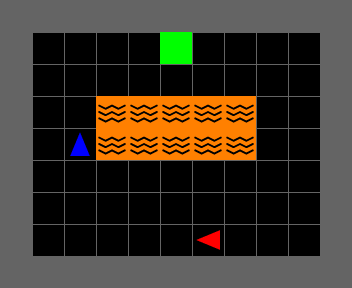

/opt/venv/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.printGrid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.printGrid` for environment variables or `env.get_attr('printGrid')` that will search the reminding wrappers.
  logger.warn(




Computing new shield
LOG: Starting with explicit model creation...
 WARN (LiftableTransitionRewardsVisitor.cpp:101): Transitionbranch-based rewards might be reduced to action-based rewards. Be sure that this is correct for your property.
Elapsed time is 1.7183713912963867 seconds.
LOG: Starting with model checking...
Elapsed time is 0.24310874938964844 seconds.
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 201
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 394
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 587
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 780
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 973
 WARN (PreShield.cpp:50): No shielding action possible with absolute comparison for state with index 1166
 WA

KeyboardInterrupt: 

In [2]:
GRID_TO_PRISM_BINARY=os.getenv("M2P_BINARY")

def mask_fn(env: gym.Env):
    return env.create_action_mask()

def nomask_fn(env: gym.Env):
    return [1.0] * 7

def main():
    env = "MiniGrid-WindyCity-Adv-v0"
    formula = "<<Agent>> Pmax=? [G<30 !(collision | AgentIsOnLava) ]"
    shield_comparison =  "absolute"

    value_for_training = 1.0
    shielding = ShieldingConfig.Training # change to ShieldingConfig.Disabled to run unshielded
    
    logger = Logger("/tmp", output_formats=[HumanOutputFormat(sys.stdout)])
    
    env = gym.make(env, render_mode="rgb_array")
    image_env = RGBImgObsWrapper(env, TILE_PIXELS)
    env = RGBImgObsWrapper(env, 8)
    env = ImgObsWrapper(env)
    env = MiniWrapper(env)

    
    env.reset()
    Image.fromarray(env.render()).show()
    
    shield_handlers = dict()
    if shield_needed(shielding):
        for value in [value_for_training]:
            shield_handler = MiniGridShieldHandler(GRID_TO_PRISM_BINARY, "grid.txt", "grid.prism", formula, shield_value=value, shield_comparison=shield_comparison, nocleanup=True, prism_file=None)
            env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handler, create_shield_at_reset=False)
            shield_handlers[value] = shield_handler

    if shielding == ShieldingConfig.Training:
        env = MiniGridSbShieldingWrapper(env, shield_handler=shield_handlers[value_for_training], create_shield_at_reset=False)
        env = ActionMasker(env, mask_fn)
        print("Training with shield:")
        create_shield_overlay_image(image_env, shield_handlers[value_for_training].create_shield())
    elif shielding == ShieldingConfig.Disabled:
        env = ActionMasker(env, nomask_fn)
    else:
        assert(False) 
    model = MaskablePPO("CnnPolicy", env, verbose=1, device="auto")
    model.set_logger(logger)
    steps = 120000

    
    model.learn(steps,callback=[InfoCallback()])



if __name__ == '__main__':
    print("Starting the training")
    main()